# Setup

## Imports

In [1]:
from collections import Counter
from copy import deepcopy
from random import choice
from typing import \
    Callable, \
    List, \
    NewType, \
    Tuple
from matplotlib import pyplot as plt

import pickle
import numpy as np

from human_data import human_data

4


## Types

In [2]:
Encounter = NewType('Encounter', int)
Position = NewType('Position', Tuple[int, int])
Reward = NewType('Reward', int)

IsGreedy = NewType('IsGreedy', bool)
Move = NewType('Move', Tuple[Position, Encounter, IsGreedy])

## Constants

In [95]:
NUM_MOVES = 20
NUM_PLAYTHROUGHS = 5

# Encounter Types
EMPTY = Encounter(0)
MONSTER = Encounter(1)
TREASURE = Encounter(2)

ENCOUNTER_TO_REWARD = {
    EMPTY: 0,
    MONSTER: -10,
    TREASURE: 10
}

ENCOUNTER_TO_REWARD_ORDERING = [EMPTY, MONSTER, TREASURE]

PLAYER_ID_TO_COLOR = {
    0: 'b',
    1: 'g',
    2: 'r',
    3: 'c'
}

STARTING_POSITION = Position((0, 0))

VALUE_ITERATION_DISCOUNT = 0.9
VALUE_ITERATION_EPSILON = 1E-1

# Classes

## Cell Class

In [4]:
class Cell:
    def __init__(self, p_empty: float, p_monster: float, p_treasure: float):
        """
        Init with probabilities set
        """
        self._p_empty = p_empty
        self._p_monster = p_monster
        self._p_treasure = p_treasure
        
    @property
    def p_empty(self):
        return self._p_empty
        
    @property
    def p_monster(self):
        return self._p_monster
        
    @property
    def p_treasure(self):
        return self._p_treasure
    
    @property
    def expectation(self):
        ps = self.p_empty, self.p_monster, self.p_treasure
        values = [ENCOUNTER_TO_REWARD[key] for key in ENCOUNTER_TO_REWARD_ORDERING]
        
        return np.sum([p * val for p, val in zip(ps, values)])
    
    def __call__(self) -> Encounter:
        """
        Returns reward
        """
        x = np.random.rand()
        
        if x < self.p_empty:
            return EMPTY
        if x < self.p_monster + self.p_empty:
            return MONSTER
        return TREASURE
    
    def __str__(self) -> str:
        p_empty = self.p_empty
        p_monster = self.p_monster
        p_treasure = self.p_treasure
        
        return f'Probability of Empty: {p_empty:.2f}\nProbability of Monster: {p_monster:.2f}\nProbability of Treasure: {p_treasure:.2f}'

### Testing

In [5]:
cell = Cell(0.2, 0.7, 0.1)
print(cell.expectation)

Counter([cell() for _ in range(100000)])

-6.0


Counter({2: 9977, 1: 69905, 0: 20118})

## Grid Class

In [6]:
class Grid:
    def __init__(self, cells: List[List[Cell]]):
        """
        Init with cells
        """
        
        self.cells = cells
        self.num_rows = len(cells)
        self.num_cols = len(cells[0])
    
    def valid_next_positions(self, position: Position) -> List[Position]:
        """
        Returns list of valid next cells
        """
        
        i, j = position
        
        valid_positions = []
        def add_position(i, j): 
            valid_positions.append(Position((i, j)))
        
        if i > 0:
            add_position(i - 1, j)
        if i < self.num_rows - 1:
            add_position(i + 1, j)
        if j > 0:
            add_position(i, j - 1)
        if j < self.num_cols - 1:
            add_position(i, j + 1)

        return valid_positions
    
    def __iter__(self):
        for i in range(self.num_rows):
            for j in range(self.num_rows):
                pos = Position((i, j))
                yield pos, self[pos]
        
    def __getitem__(self, position: Position):
        i, j = position
        return self.cells[i][j]

### Testing

In [7]:
I, J = 3, 3

cells = []
for _ in range(I):
    row = []
    for _ in range(J):
        x = np.random.rand()
        y = np.random.rand() * (1 - x)
        z = 1 - x - y
        
        probabilities = [x, y, z]
        np.random.shuffle(probabilities)
        
        row.append(Cell(*probabilities))
        
    cells.append(row)

grid = Grid(cells)

print(grid.valid_next_positions((1,1)))
print(grid[1, 1])
print(grid[1, 2] == cells[1][2])

[(0, 1), (2, 1), (1, 0), (1, 2)]
Probability of Empty: 0.20
Probability of Monster: 0.11
Probability of Treasure: 0.69
True


## ModelCell and ModelGrid Classes

In [8]:
class ModelCell(Cell):
    def __init__(self):
        """
        Init, tracking with num encounters etc
        """
        self.value = 0
        self.num_encounters = 0
        self.encounters = {
            EMPTY: 0,
            MONSTER: 0,
            TREASURE: 0
        }
        
        super().__init__(0, 0, 0)
    
    @Cell.p_empty.getter
    def p_empty(self):
        if self.num_encounters == 0:
            return 1/3
        
        return self.encounters[EMPTY] / self.num_encounters

    @Cell.p_monster.getter
    def p_monster(self):
        if self.num_encounters == 0:
            return 1/3
        
        return self.encounters[MONSTER] / self.num_encounters
        
    @Cell.p_treasure.getter
    def p_treasure(self):
        if self.num_encounters == 0:
            return 1/3
        
        return self.encounters[TREASURE] / self.num_encounters
    
    def update(self, encounter: Encounter):
        """
        Update encounters tracking with encounter
        """
        
        self.num_encounters += 1
        self.encounters[encounter] += 1
        
class ModelGrid(Grid):
    def __init__(self, num_rows, num_cols):
        cells = [[ModelCell() for _ in range(num_cols)] for _ in range(num_rows)]
        super().__init__(cells)
    
    def update(self, position: Position, encounter: Encounter):
        """
        Update cell in position with encounter e.g. monster
        """
        
        self[position].update(encounter)
        self.value_iteration()
        
    def value_iteration(self, epsilon=VALUE_ITERATION_EPSILON):
        delta = np.inf
        while delta > epsilon:
            delta = 0
            prev_model_grid = deepcopy(self)

            for pos, cell in prev_model_grid:
                prev_val = cell.value
                valid_positions = self.valid_next_positions(pos)
                additive_value = np.mean([prev_model_grid[pos].value for pos in valid_positions])
                next_val = cell.expectation + VALUE_ITERATION_DISCOUNT * additive_value

                delta = max(delta, abs(next_val - prev_val))
                self[pos].value = next_val

    def print(self, player_pos: Position, use_expectation: bool = True, reveal_all: bool = False) -> str:
        """
        Pretty print board with player's position. Defaults to using cell expectation, else cell value
        """
        strings = []
        cells = self.cells
        
        
        for i in range(self.num_rows):
            for j in range(self.num_cols):
                strings.append('|')
                cell_pos = Position((i, j))
                
                if cell_pos == player_pos:
                    strings.append(' P  | ')
                elif cell_pos in grid.valid_next_positions(player_pos) or reveal_all:
                    cell = self[cell_pos]
                    value = cell.expectation if use_expectation else cell.value
                    strings.append(f'{value:4.1f}| ')
                else:
                    strings.append('   x| ')
            strings.append('\n')
                
        print(''.join(strings))

### Testing

In [9]:
cell = ModelCell()

print(Counter([cell() for _ in range(10000)]))

cell.update(EMPTY)
print(Counter([cell() for _ in range(10000)]))
cell.update(np.random.choice([MONSTER, TREASURE]))
print(Counter([cell() for _ in range(10000)]))

cell.expectation

model_grid = ModelGrid(3, 3)
position = Position((1,1))

print(model_grid[position].expectation == 0)
model_grid.update(position, TREASURE)
print(model_grid[position].expectation == 10)
model_grid.update(Position((1,2)), MONSTER)

player_position = Position((1,0))
model_grid.print(player_position)

Counter({1: 3387, 0: 3355, 2: 3258})
Counter({0: 10000})
Counter({2: 5044, 0: 4956})
True
True
| 0.0| |   x| |   x| 
| P  | |10.0| |   x| 
| 0.0| |   x| |   x| 



## Game Class

In [10]:
class Game:
    def __init__(self, grid: Grid):
        """
        Init with grid
        """
        self.grid = grid
        
    def evaluate(self, pos: Position) -> Encounter:
        return self.grid[pos]()
    
    def print(self, player_pos: Position) -> str:
        """
        Pretty print board with player's position
        """
        strings = []
        grid, cells = self.grid, self.grid.cells
        
        for i in range(grid.num_rows):
            for j in range(grid.num_cols):
                strings.append('|')
                cell_pos = Position((i, j))
                
                if cell_pos == player_pos:
                    strings.append('P| ')
                elif cell_pos in grid.valid_next_positions(player_pos):
                    strings.append(' | ')
                else:
                    strings.append('x| ')
            strings.append('\n')
                
        print(''.join(strings))

### Testing

In [11]:
Game(grid).print(Position((1,2)))

|x| |x| | | 
|x| | | |P| 
|x| |x| | | 



## History Class

In [60]:
class History:
    def __init__(self):
        self.curr_playthrough: List[Move] = []
        self.playthroughs: List[List[Move]] = [self.curr_playthrough]
            
    def track(self, move: Move):
        self.curr_playthrough.append(move)
        
    def start_new_playthrough(self):
        if len(self.playthroughs) >= NUM_PLAYTHROUGHS:
            return
        self.curr_playthrough: List[Move] = []
        self.playthroughs.append(self.curr_playthrough)
        
    @property
    def rewards(self) -> List[Reward]:
        rewards = [
            Reward(np.sum(
                [ENCOUNTER_TO_REWARD[encounter] for _, encounter, _ in playthrough]
            ))
            for playthrough in self.playthroughs
        ]
        
        return rewards
    
    @property
    def num_exploratory_moves(self) -> int:
        return [
            sum([not is_greedy for _, _, is_greedy in playthrough])
            for playthrough in self.playthroughs
        ]
    
    @property
    def reward(self) -> Reward:
        return float(np.sum(self.rewards))
    
    @staticmethod
    def from_human_data(data):
        SEEN_TO_ENCOUNTER = {
            'neutral': EMPTY,
            'monster': MONSTER,
            'treasure': TREASURE
        }
        
        data.sort(key=lambda d: d['rounds'])
        playthroughs = []
        model_grid = ModelGrid(5,5)
        
        prev_pos = None
        
        encounters_by_cell_pos = {}
        num_new_moves_by_playthrough = []
        for raw_playthrough in data:
            playthrough = []
            num_new_moves = 0
            for i, j, seen in raw_playthrough['history']:
                pos = Position((i, j))
                encounter = SEEN_TO_ENCOUNTER[seen]
                
                   
                if not prev_pos:
                    is_greedy = False
                else:
                    valid_positions = model_grid.valid_next_positions(prev_pos)
                    greedy_pos = max(
                        valid_positions,
                        key=lambda pos: np.mean(encounters_by_cell_pos[pos]) if pos in encounters_by_cell_pos else 0
                    )
                    is_greedy = greedy_pos == pos
                    
                if pos not in encounters_by_cell_pos:
                    encounters_by_cell_pos[pos] = []
                    num_new_moves += 1

                encounters_by_cell_pos[pos].append(encounter)
                playthrough.append(Move(
                    (pos, encounter, is_greedy)
                ))
            
            playthroughs.append(playthrough)
            num_new_moves_by_playthrough.append(num_new_moves)
            prev_pos = pos
            
        history = History()
        history.num_new_moves = num_new_moves_by_playthrough
        history.playthroughs = playthroughs
        
        return history
                    

## Player Class

In [61]:
StrategyFunction = NewType('StrategyFunction', Callable[[Grid, Position], Cell])

class Player:
    def __init__(
        self,
        game: Game,
        strategy_fn: StrategyFunction,
        num_moves:int = NUM_MOVES,
        num_playthroughs=NUM_PLAYTHROUGHS
    ):
        """
        Init with strategy function, model grid, history
        """
        
        self.game = game
        self.strategy_fn = strategy_fn
        self.remaining_moves = num_moves
        self.remaining_playthroughs = num_playthroughs
        self.num_moves_per_playthrough = num_moves
        
        self.init_pos()
        self.history = History()
        self.model_grid = ModelGrid(game.grid.num_rows, game.grid.num_cols)
        
    def start_new_playthrough(self):
        self.remaining_playthroughs -= 1
        self.remaining_moves = self.num_moves_per_playthrough
        self.init_pos()
        self.history.start_new_playthrough()
    
    def play_next_move(self, display=False):
        """
        Perform next move according to strategy function
        """
        
        if self.remaining_moves <= 0:
            if self.remaining_playthroughs <= 0:
                raise ValueError('Oi! No more moves or playthroughs!')
                
            self.start_new_playthrough()
        
        next_pos, is_greedy = self.strategy_fn(self.model_grid, self.pos)
        encounter = self.game.evaluate(next_pos)
        
        self.model_grid.update(next_pos, encounter)
        
        move = Move((next_pos, encounter, is_greedy))
        self.history.track(move)
        self.pos = next_pos
        self.remaining_moves -= 1
        
        if display:
            print(f'Reward: {self.history.reward}')
            print(f'Move is greedy: {is_greedy}')
            self.model_grid.print(self.pos, reveal_all=True)
        
    def init_pos(self):
        self.pos = Position((game.grid.num_rows // 2, game.grid.num_cols // 2))
    
    def play_next_playthrough(self, display=False) -> History:
        """
        Play until remaining moves expended, then return History
        """
        if self.remaining_playthroughs <= 0:
            raise ValueError('Oi! No more playthroughs!')
            
        while self.remaining_moves:
            self.play_next_move(display)
            
        self.start_new_playthrough()
        
    def play(self, display=False):
        if self.remaining_playthroughs <= 0:
            raise ValueError('Oi! No more playthroughs!')
            
        while self.remaining_playthroughs:
            self.play_next_playthrough(display)

# Strategy Functions

## $\varepsilon\text{-greedy}$

In [62]:
def epsilon_greedy_maker(epsilon: float) -> StrategyFunction:
    def epsilon_greedy(model_grid: ModelGrid, position: Position) -> Position:
        is_greedy = np.random.rand() > epsilon
        
        valid_positions = model_grid.valid_next_positions(position)
        greedy_position = max(valid_positions, key=lambda p: model_grid[p].value)
        
        if is_greedy:
            return greedy_position, is_greedy
        
        position = greedy_position
        while position == greedy_position:
            position = choice(valid_positions)
            
        return position, is_greedy
    
    return epsilon_greedy

### Testing

In [63]:
greedyhalf = epsilon_greedy_maker(0.5)
player_pos = Position((1,0))
I, J = 3, 3

model_grid = ModelGrid(I, J)
position = Position((1,1))
model_grid.update(position, TREASURE)

model_grid.print(player_pos)

print( greedyhalf(model_grid, player_pos) )

| 0.0| |   x| |   x| 
| P  | |10.0| |   x| 
| 0.0| |   x| |   x| 

((1, 1), True)


## $\alpha\text{-index}$, Maximin, Maximax

In [64]:
def alpha_index_maker(alpha: float) -> StrategyFunction:
    def alpha_index(grid: Grid, position: Position) -> Position:
        def evaluate_position(position: Position) -> float:
            cell = grid[position]
            probabilities = cell.p_empty, cell.p_monster, cell.p_treasure
            
        valid_positions = grid.valid_next_positions(position)
        
    
maximin: StrategyFunction = alpha_index_maker(0)
maximax: StrategyFunction = alpha_index_maker(1)

# Playing

### Setup Random Game

In [65]:
I, J = 3, 3

cells = []
for _ in range(I):
    row = []
    for _ in range(J):
        x = np.random.rand()
        y = np.random.rand() * (1 - x)
        z = 1 - x - y
        
        probabilities = [x, y, z]
        np.random.shuffle(probabilities)
        
        row.append(Cell(*probabilities))
        
    cells.append(row)

grid = Grid(cells)
game_random = Game(grid)

## Setup Actual Game

In [66]:
# [[[empty, monster, treasure]]]
data = [[[0.3878219196112134,0.19759672197559452,0.4145813584131921],[0.37018831461569657,0.02794500443185699,0.6018666809524464],[0.6992744657871455,0.012917539448003224,0.2878079947648513],[0.7551581580257278,0.21883616177828769,0.026005680195984482],[0.02217520649536797,0.8593558949990283,0.11846889850560371]],[[0.6553520279778058,0.2552861011127885,0.08936187090940573],[0.283172417088295,0.17419479253578052,0.5426327903759245],[0.22945274994524922,0.7461638890739508,0.024383360980799962],[0.7609087236740122,0.17005000433317896,0.06904127199280885],[0.034922855165913536,0.49597325775947976,0.4691038870746067]],[[0.16436569193686812,0.7975663084635969,0.038067999599534996],[0.09426376430786765,0.21448465845076425,0.6912515772413681],[0.033037349287953655,0.9059765747471451,0.06098607596490124],[0.7817253912202893,0.11920133225443519,0.09907327652527553],[0.08117608091026218,0.4755560522260003,0.44326786686373754]],[[0.44068247200850585,0.4599243375472921,0.09939319044420203],[0.13747855528933162,0.04062411610008909,0.8218973286105793],[0.08262552114158672,0.5488324749946589,0.36854200386375435],[0.15994884407939858,0.5215699615878777,0.3184811943327237],[0.02503774132988279,0.8599172345994779,0.11504502407063932]],[[0.01982759030885628,0.8376737791237576,0.1424986305673861],[0.6416851854069987,0.28807426567342764,0.07024054891957365],[0.6102308845033342,0.2638689165672785,0.1259001989293873],[0.2510901849738849,0.7414758929487386,0.007433922077376476],[0.2898359244814934,0.12410037921850647,0.5860636963000001]]]

cells = []
for probabilities_row in data:
    row = []
    for probabilities in probabilities_row:
        row.append(Cell(*probabilities))
        
    cells.append(row)
    
grid = Grid(cells)
game = Game(grid)

## Load/Perform epsilon-greedy playthroughs as baseline

In [67]:
def run(epsilon_greed=0.2) -> History:
    player = Player(
        game,
        epsilon_greedy_maker(epsilon_greed),
    )
    
    player.play()
    return player.history

In [68]:
def generate_histories_by_epsilon():
    NUM_SAMPLES = 30

    epsilons = np.linspace(0, 1, 6)
    histories_by_epsilon = {}

    for epsilon in epsilons:
        histories = []
        for i in range(NUM_SAMPLES):
            histories.append(run(epsilon))
            if (i + 1) % 10 == 0:
                print(f'Done with run {i + 1}/{NUM_SAMPLES} for epsilon {epsilon:.1f}')

        histories_by_epsilon[epsilon] = histories
        
    pickle.dump(histories_by_epsilon, open('histories_by_epsilon.p', 'wb'))
    return histories_by_epsilon

histories_by_epsilon = pickle.load(open('histories_by_epsilon.p', 'rb'))
# histories_by_epsilon = generate_histories_by_epsilon()

single_histories_by_epsilon = {epsilon: histories[0] for epsilon, histories in histories_by_epsilon.items()}

## Load Human Histories

In [69]:
human_histories = [History.from_human_data(data) for data in human_data]

# Plots

## Rewards vs Round

In [70]:
mean_rewards_by_epsilon = {}
for epsilon, histories in histories_by_epsilon.items():
    mean_rewards_by_epsilon[epsilon] = np.mean(
        [history.rewards for history in histories],
        axis=0
    )

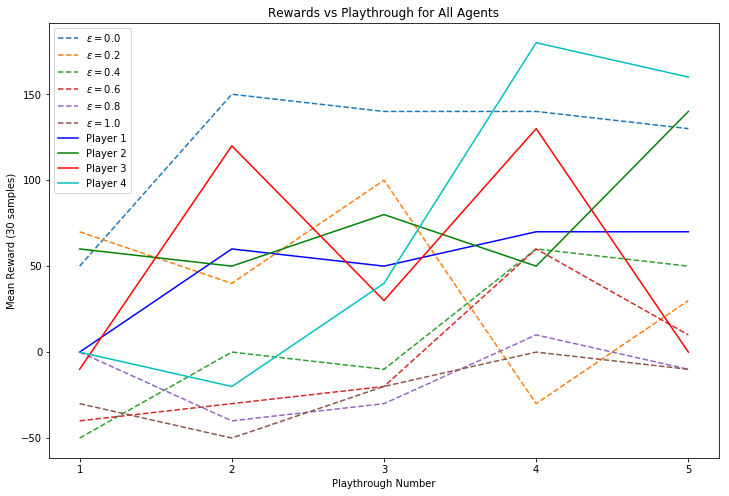

In [96]:
fig, ax = plt.subplots(figsize=(12, 8))
for epsilon, history in single_histories_by_epsilon.items():
    mean_rewards = history.rewards
    ax.plot(
        range(1, NUM_PLAYTHROUGHS + 1),
        mean_rewards,
        label=r'$\varepsilon =$' + f'{epsilon:.1f}',
        linestyle='--'
    )
    
for i, history in enumerate(human_histories):
    ax.plot(
        range(1, NUM_PLAYTHROUGHS + 1),
        history.rewards[:5],
        label=f'Player {i + 1}',
        c=PLAYER_ID_TO_COLOR[i]
    )
 
    
ax.set_xlabel('Playthrough Number')    
ax.set_ylabel('Mean Reward (30 samples)')    
ax.set_title('Rewards vs Playthrough for All Agents')

ax.set_xticks(range(1, NUM_PLAYTHROUGHS + 1))
ax.legend()

fig.savefig('img/rewards-vs-playthrough.png', dpi=300)

## Exploratory moves vs Playthrough

In [72]:
mean_exploratory_moves_by_epsilon = {}
for epsilon, histories in histories_by_epsilon.items():
    mean_exploratory_moves_by_epsilon[epsilon] = np.mean(
        [history.num_exploratory_moves for history in histories],
        axis=0
    )

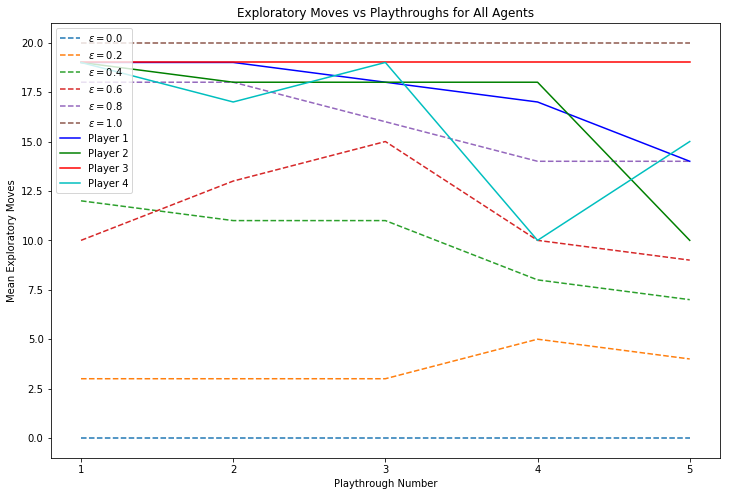

In [97]:
fig, ax = plt.subplots(figsize=(12, 8))
for epsilon, history in single_histories_by_epsilon.items():
    mean_moves = history.num_exploratory_moves
    ax.plot(
        range(1, NUM_PLAYTHROUGHS + 1),
        mean_moves,
        label=r'$\varepsilon =$' + f'{epsilon:.1f}',
        linestyle='--'
    )
    
for i, history in enumerate(human_histories):
    ax.plot(
        range(1, NUM_PLAYTHROUGHS + 1),
        history.num_exploratory_moves[:5],
        label=f'Player {i + 1}',
        c=PLAYER_ID_TO_COLOR[i]
    )
 
    
ax.set_xlabel('Playthrough Number')    
ax.set_ylabel('Mean Exploratory Moves')    
ax.set_title('Exploratory Moves vs Playthroughs for All Agents')

ax.set_xticks(range(1, NUM_PLAYTHROUGHS + 1))
ax.legend(loc='upper left')
fig.savefig('img/exploratory-moves-vs-playthrough.png', dpi=300)

## New Moves vs Playthrough

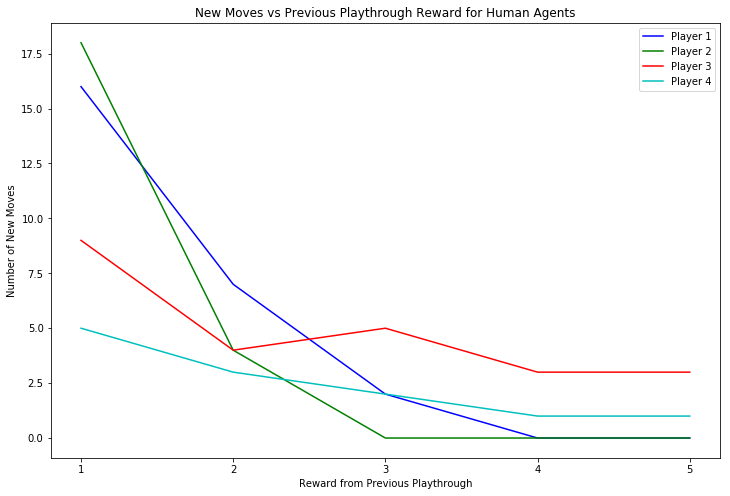

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))
    
for i, history in enumerate(human_histories):
    moves = history.num_new_moves[:5]
    ax.plot(
        range(1, NUM_PLAYTHROUGHS + 1),
        moves,
        label=f'Player {i + 1}',
        c=PLAYER_ID_TO_COLOR[i]
    )
 
    
ax.set_xlabel('Reward from Previous Playthrough')    
ax.set_ylabel('Number of New Moves')
ax.set_title('New Moves vs Previous Playthrough Reward for Human Agents')

ax.set_xticks(range(1, NUM_PLAYTHROUGHS + 1))
ax.legend()

fig.savefig('img/new-moves-vs-playthrough.png', dpi=300)

## Exploratory Moves vs Reward from Previous Playthrough

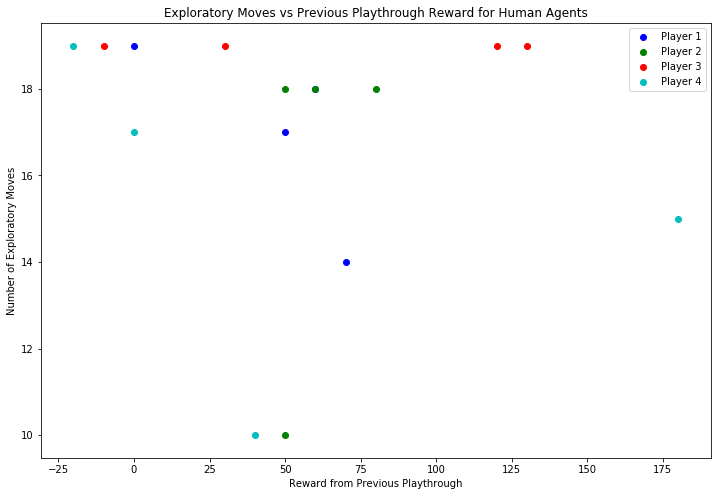

In [101]:
fig, ax = plt.subplots(figsize=(12, 8))
    
for i, history in enumerate(human_histories):
    rewards = history.rewards[0:4]
    moves = history.num_exploratory_moves[1:5]
    ax.scatter(
        rewards,
        moves,
        label=f'Player {i + 1}',
        c=PLAYER_ID_TO_COLOR[i]
    )
 
    
ax.set_xlabel('Reward from Previous Playthrough')    
ax.set_ylabel('Number of Exploratory Moves')
ax.set_title('Exploratory Moves vs Previous Playthrough Reward for Human Agents')

# ax.set_xticks(range(1, NUM_PLAYTHROUGHS + 1))
ax.legend()
fig.savefig('img/exploratory-moves-vs-previous-playthrough-reward.png', dpi=300)

## New Moves vs Reward from Previous Cycle

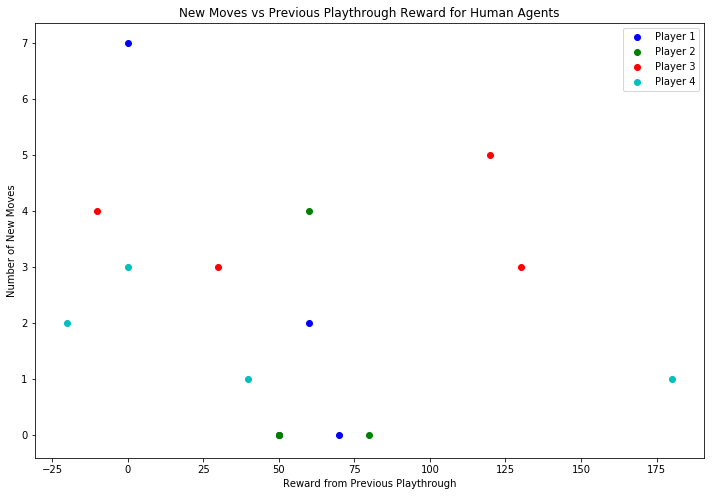

In [100]:
fig, ax = plt.subplots(figsize=(12, 8))
    
for i, history in enumerate(human_histories):
    rewards = history.rewards[0:4]
    moves = history.num_new_moves[1:5]
    ax.scatter(
        rewards,
        moves,
        label=f'Player {i + 1}',
        c=PLAYER_ID_TO_COLOR[i]
    )
 
    
ax.set_xlabel('Reward from Previous Playthrough')    
ax.set_ylabel('Number of New Moves')
ax.set_title('New Moves vs Previous Playthrough Reward for Human Agents')

ax.legend()
fig.savefig('img/new-moves-vs-previous-playthrough-reward.png', dpi=300)

In [ ]:
run(num_moves=10, display=True, epsilon_greedm=0.3)